# Scaling energy use by occupancy

Please see the corresponding section in `../METHODOLOGY.md` for more context.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [3]:
# Data from AER Climate Zone 6 averages
sizes = np.array([1, 2, 3, 4])  # Excluding the "5+" category
ratios = np.array([1.0, 1.65, 1.75, 1.97])

In [4]:
def power_law(x, a, b):
    """Power law function: y = a * x^b"""
    return a * (x ** b)

def logarithmic(x, a, b):
    """Logarithmic function: y = a + b * log(x)"""
    return a + b * np.log(x)

# Define additional fitting functions
def exponential(x, a, b, c):
    """Exponential function with offset: y = a * (1 - exp(-b * (x - 1))) + c"""
    return a * (1 - np.exp(-b * (x - 1))) + c

def logistic(x, L, k, x0):
    """Logistic function: L / (1 + exp(-k*(x-x0)))"""
    return L / (1 + np.exp(-k*(x-x0)))

In [5]:
# Perform curve fitting
# Power Law Fit
popt_power, _ = optimize.curve_fit(power_law, sizes, ratios)
a_power, b_power = popt_power

# Logarithmic Fit
popt_log, _ = optimize.curve_fit(logarithmic, sizes, ratios)
a_log, b_log = popt_log

# Exponential Fit
popt_exp, _ = optimize.curve_fit(
    exponential,
    sizes,
    ratios,
    p0=[1, 1, 1],  # initial guesses
    bounds=([0, 0, 0], [10, 10, 2]),
)
a_exp, b_exp, c_exp = popt_exp

# Logistic Fit
popt_logistic, _ = optimize.curve_fit(
    logistic,
    sizes,
    ratios,
    p0=[2, 1, 2],  # initial guesses
    bounds=([0, 0, 1], [10, 10, 3]),
)
L_logistic, k_logistic, x0_logistic = popt_logistic

In [6]:
# Interpolation for 2.7 occupants
def interpolate_multiplier(x, method='power_law'):
    if method == 'power_law':
        return power_law(x, a_power, b_power)
    
    elif method == 'logarithmic':
        return logarithmic(x, a_log, b_log)
    
    elif method == 'exponential':
        return exponential(x, a_exp, b_exp, c_exp)
    
    elif method == 'logistic':
        return logistic(x, L_logistic, k_logistic, x0_logistic)

In [7]:
print("Interpolation at 2.7 occupants:")
print(f"Power Law Interpolation: {interpolate_multiplier(2.7, 'power_law'):.6f}")
print(f"Logarithmic Interpolation: {interpolate_multiplier(2.7, 'logarithmic'):.6f}")
print(f"Exponential Interpolation: {interpolate_multiplier(2.7, 'exponential'):.6f}")
print(f"Exponential Interpolation: {interpolate_multiplier(2.7, 'logistic'):.6f}")


Interpolation at 2.7 occupants:
Power Law Interpolation: 1.695833
Logarithmic Interpolation: 1.727450
Exponential Interpolation: 1.787571
Exponential Interpolation: 1.808849


In [8]:
# Generate smooth curves for plotting
x_smooth = np.linspace(1, 4, 100)
power_fit = power_law(x_smooth, a_power, b_power)
log_fit = logarithmic(x_smooth, a_log, b_log)
exp_fit = exponential(x_smooth, a_exp, b_exp, c_exp)
logistic_fit = logistic(x_smooth, L_logistic, k_logistic, x0_logistic)

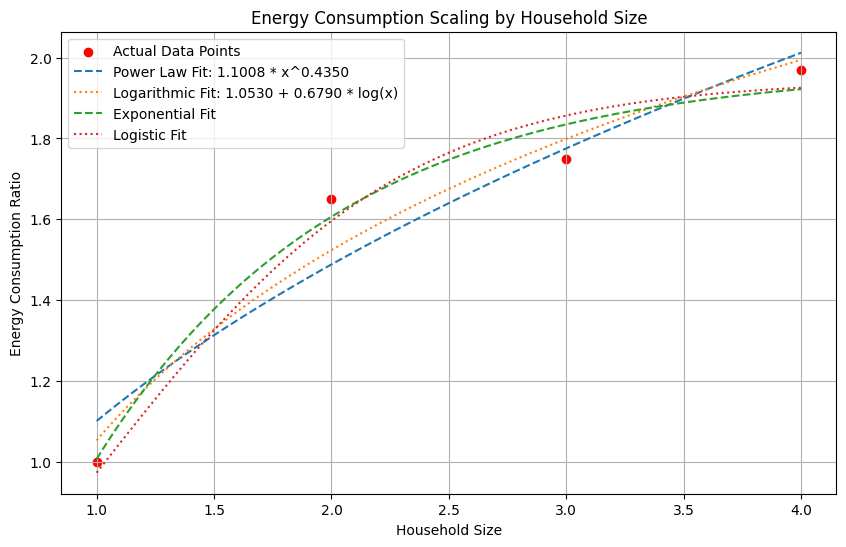

In [9]:
# Plotting the original data points
plt.figure(figsize=(10, 6))
plt.scatter(sizes, ratios, color='red', label='Actual Data Points')
plt.xlabel('Household Size')
plt.ylabel('Energy Consumption Ratio')
plt.title('Energy Consumption Scaling by Household Size')

# Plot the fitted curves
plt.plot(x_smooth, power_fit, label=f'Power Law Fit: {a_power:.4f} * x^{b_power:.4f}', linestyle='--')
plt.plot(x_smooth, log_fit, label=f'Logarithmic Fit: {a_log:.4f} + {b_log:.4f} * log(x)', linestyle=':')
plt.plot(x_smooth, exp_fit, label=f'Exponential Fit', linestyle='--')
plt.plot(x_smooth, logistic_fit, label=f'Logistic Fit', linestyle=':')

plt.legend()
plt.grid(True)
plt.show()

Exponential fit seems best here. 

In [15]:

reference_ratio = exponential(2.7, a_exp, b_exp, c_exp)

print('Ratios')
for x in range(1,5):
    print(f"{x}: {exponential(x, a_exp, b_exp, c_exp)}")
print(f"{2.7}: {exponential(2.7, a_exp, b_exp, c_exp)}")

print('Multipliers')
for x in range(1,5):
    print(f"{x}: {exponential(x, a_exp, b_exp, c_exp)/reference_ratio}")
print(f"{2.7}: {exponential(2.7, a_exp, b_exp, c_exp)/reference_ratio}")

Ratios
1: 1.0069914114164153
2: 1.6063272508733757
3: 1.8347946663176926
4: 1.921886671306249
2.7: 1.7875709005028604
Multipliers
1: 0.5633294943060101
2: 0.8986089728924883
3: 1.0264178421127508
4: 1.0751387096118001
2.7: 1.0


For the 5+ category, scale the multiplier using the relative energy consumption increase from 4 to 5+ occupants in the original data.

In [11]:
1.0751387096118001 * (1+(2018-1583)/1583)

1.3705811219182644